# Normalized Leaky (and Guided?) Modes

We are near the end of the journey on this.  We found an explicit formula for the residues of the spectral integrand (using the eigenvector normalization of radiation modes) and now we can calculate them exactly.  (This was debugged in the Exact_Residues notebook).  This should make calculating the leaky field as simple as calculating the guided field (and in fact both should simplify because the integrals in the denominator should no longer be necessary to calculate).  Let's see if it's working here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from slab import SlabExact, plot_complex, plot_complex_surface
from scipy.optimize import newton
from scipy.integrate import quad
plt.style.use('dark_background')
%matplotlib widget

In [2]:
A = SlabExact(symmetric=True, Ts=[3, 2, 3])


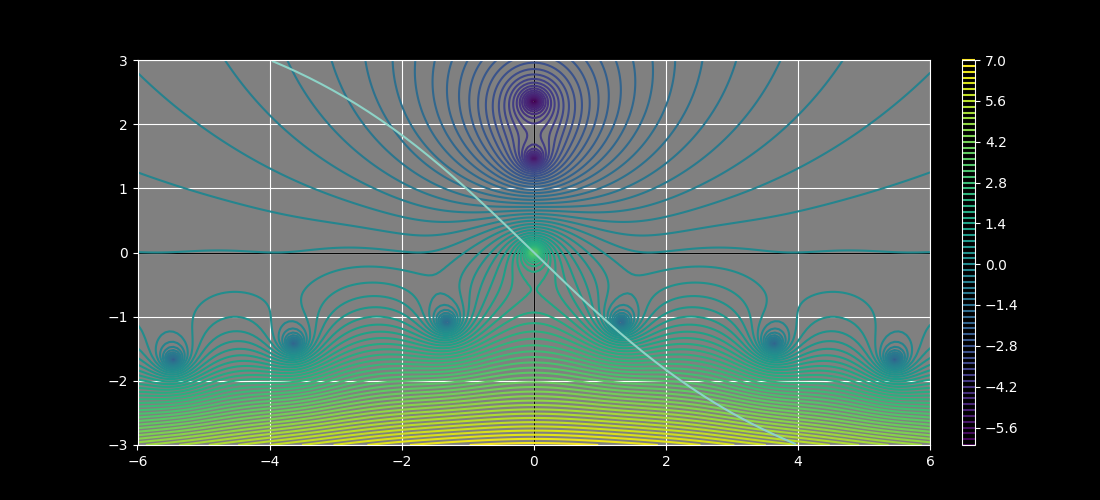

In [3]:
_, ax1 = A.determinant_plot(-6, 6, -3, 3)

In [4]:
Zg1 = newton(A.determinant, np.array(2.2j))
Zg2 = newton(A.determinant, np.array(1.5j))
A.plot_points([Zg1, Zg2], ax=ax1)

In [5]:
Fg = A.fields(Zg1)
Fg2 = A.fields(Zg2)

In [6]:
Fg(1)

array([0.3610057-9.48756866e-18j])

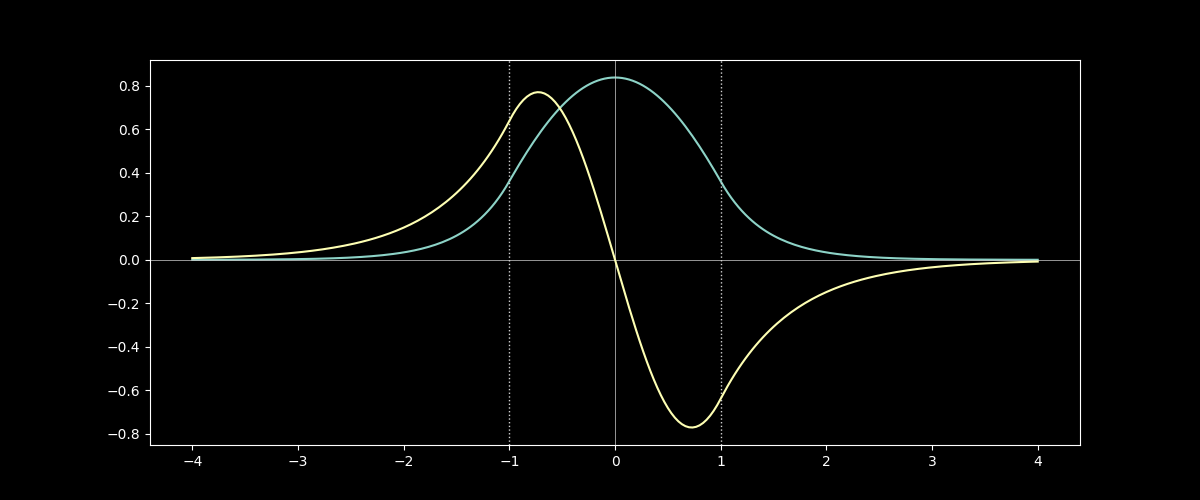

In [7]:
A.plot_field_1d(lambda x: Fg(x)**1, part='real');
A.add_1d_plot(lambda x: Fg2(x)**1)

In [8]:
quad(lambda x: Fg(x)**2, -10, 10, complex_func=True)[0], quad(lambda x: Fg2(x)**2, -10, 10, complex_func=True)[0]

((0.9999999999606157-5.221584973585043e-18j),
 (0.999999999870006+6.056130111870811e-17j))

Okay yes, we're really close.  But some scaling is still off.  For now, let's move forward and scale on our own to see if it works for an input field.

I think I get it now: when you calculate the residues you use the spectral integrand itself, which has a factor of -1/2pi in it.  So you put those in the modes (with a square root) when you want to form the residues.  But the residues are not equal to the contour integrals, they are equal to them times a factor of 2 pi i.  So to get the contour integral part you need to include the 2 pi i into the mode too (again with a square root). This cancels the 2 pi in the denominator and adds in an imaginary unit.  I'm still not sure why the negative sign needs to cancel as well, but it does.

Maybe that last part is because of the direction of the contour integral.  We want clockwise in this case, so we really would need to scale the residue by -2 pi i.  I'm guessing this is why.

In [9]:
b = .5
a = 1/ b**2
def quadratic_piecewise(x):
    conds = [(x<-b), ((-b<=x)*(x<=b)), (x>b)]
    funcs = [0, lambda x: 1 - a * x**2, 0]
    return np.piecewise(x, conds, funcs)

f0 = quadratic_piecewise

In [10]:
alpha_guided = quad(lambda x: Fg(x)*f0(x), -10, 10, complex_func=True)[0]
guided = lambda x: alpha_guided * Fg(x)

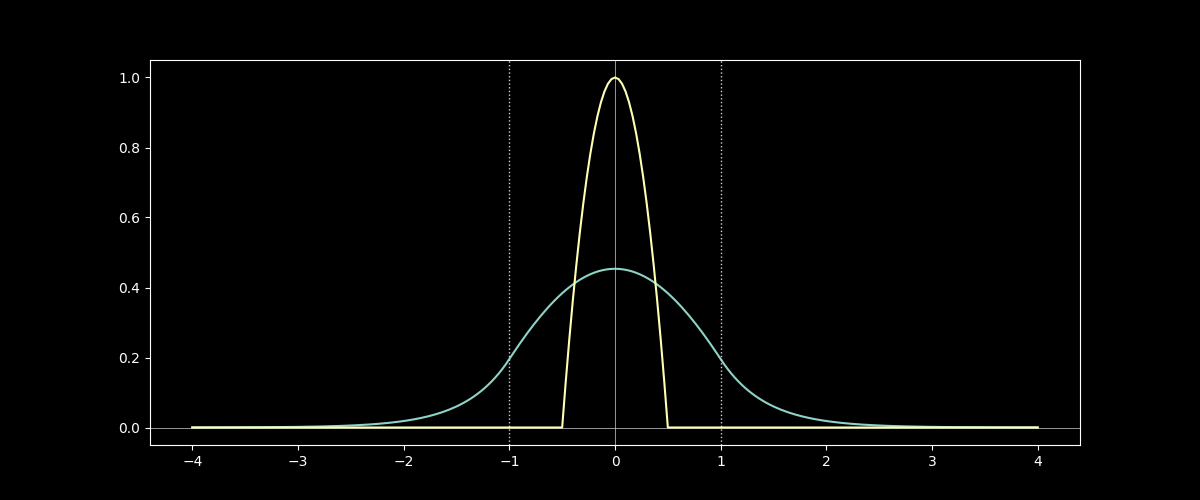

In [11]:
A.plot_field_1d(guided)
A.add_1d_plot(f0)

Now let's do the leaky field

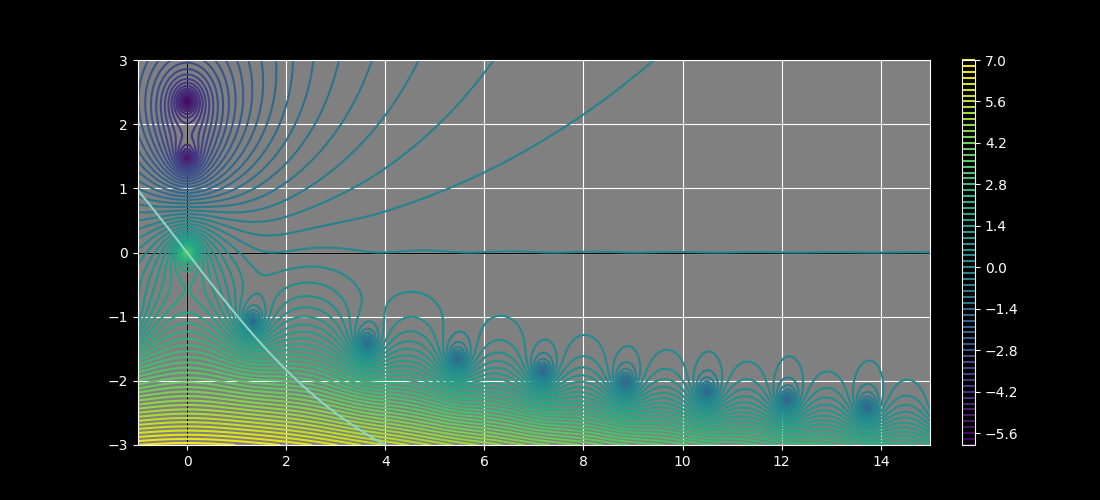

In [12]:
A.determinant_plot(-1, 15, -3, 3);

In [13]:
leaky_guesses = [1.7 - 1j,
                 4 - 1.3j,
                 5.5-1.8j,
                 7 - 2.0j,
                 9 - 2.0j,
                 10.5 -2j,
                 12 - 2j,
                ]

Z_leakys = np.array([newton(A.determinant, np.array(guess))[0] for guess in leaky_guesses])
A.plot_points(Z_leakys)

In [14]:
F_leakys = [A.fields(Z) for Z in Z_leakys]

In [15]:
alpha_leakys = [quad(lambda x: F(x)*f0(x), -b, b, complex_func=True)[0] for F in F_leakys]
leaky_exact_x = lambda x: sum([alpha * F(x) for alpha, F in zip(alpha_leakys, F_leakys)])

In [16]:
Propagator_Class = A.propagator()
Eig = A.normalizer('eigvec')
Ours = A.normalizer('ours')
Paper = A.normalizer('paper')

(<Figure size 1100x500 with 2 Axes>, <Axes: >)

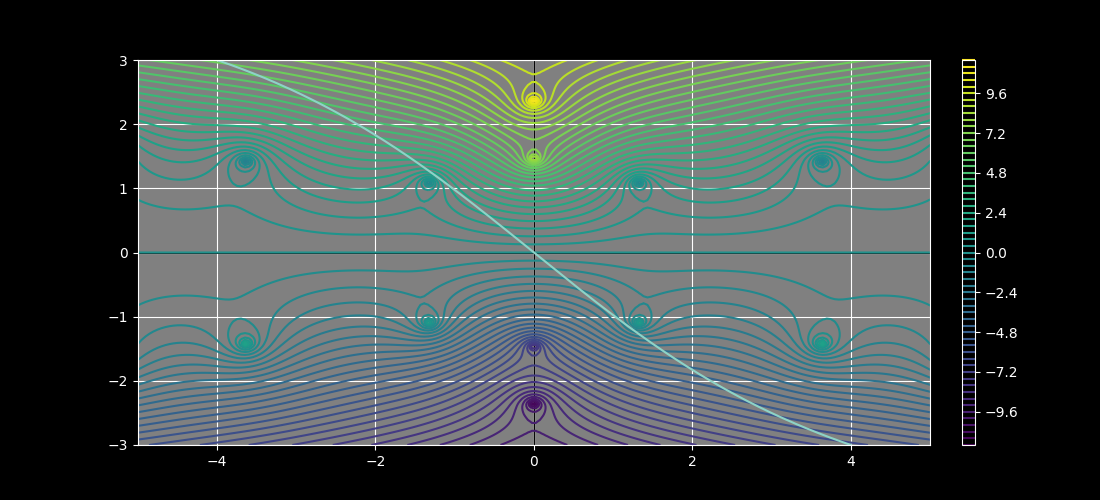

In [17]:
A.determinant_plot(-5, 5, -3, 3, mode_type='radiation', Normalizer=Paper)

In [18]:
P_leaky_even = [Propagator_Class(A.circular_contour(-Zl, .01, 10, orientation='ccw'), f0=f0, Lx=-b, Rx=b, sign=1, Normalizer=Paper) for Zl in Z_leakys]
P_leaky_odd = [Propagator_Class(A.circular_contour(-Zl, .01, 10, orientation='ccw'), f0=f0, Lx=-b, Rx=b, sign=-1, Normalizer=Paper) for Zl in Z_leakys]

P_leaky = P_leaky_even 

In [19]:
leaky_contour_x = lambda x: sum([P.slice_propagate(x) for P in P_leaky])
ratio = lambda x: leaky_exact(x) / leaky_contour(x)

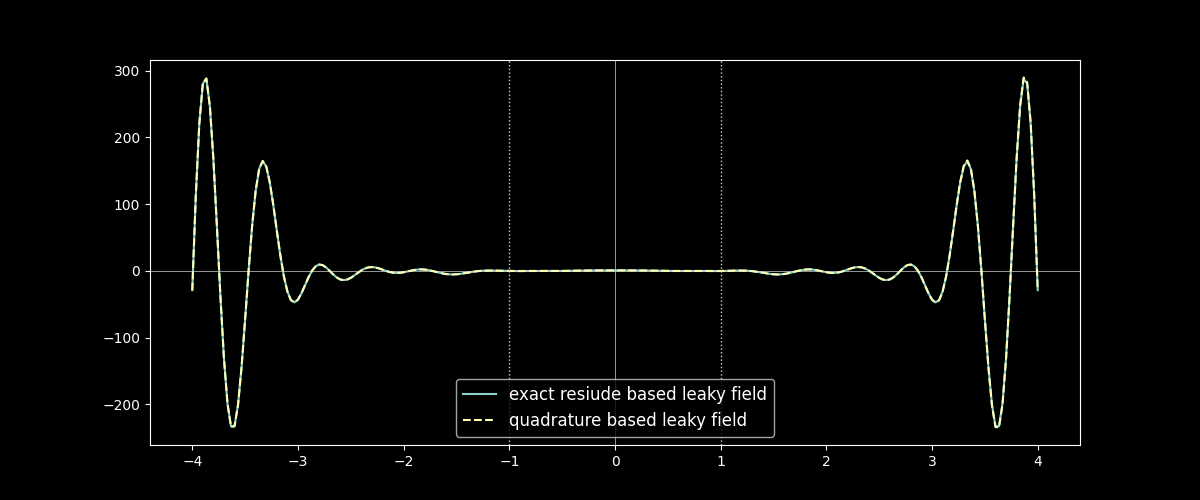

In [20]:
A.plot_field_1d(leaky_exact_x, label='exact resiude based leaky field')
A.add_1d_plot(leaky_contour_x, ls='--', label='quadrature based leaky field')
# A.add_1d_plot(ratio)

Yep!!!! We are finally there!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [21]:
P_prop1 = Propagator_Class(A.real_contour(0.00001, A.Z_evanescent, 100), f0=f0, Lx=-b, Rx=b, Normalizer=Paper)
P_prop2 = Propagator_Class(A.real_contour(0.00001, A.Z_evanescent, 100), f0=f0, Lx=-b, Rx=b, Normalizer=Paper, sign=-1)
P_ev1 = Propagator_Class(A.real_contour(A.Z_evanescent, 60, 300), f0=f0, Lx=-b, Rx=b, Normalizer=Paper)
P_ev2 = Propagator_Class(A.real_contour(A.Z_evanescent, 60, 300), f0=f0, Lx=-b, Rx=b, Normalizer=Paper, sign=-1)

(<Figure size 1100x400 with 1 Axes>, <Axes: >)

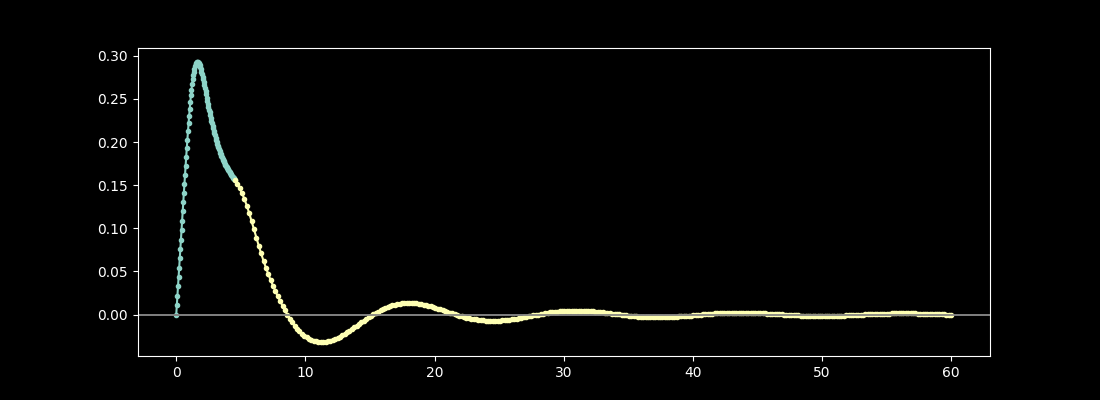

In [22]:
P_prop1.plot_transform()
P_ev1.plot_transform(ax=plt.gca())

In [39]:
P_prop1.propagate([1,2,3],4)

array([[ 0.07236295+0.12366706j, -0.10910592+0.14170348j,
        -0.06001677-0.12243014j]])

In [22]:
prop_x = lambda x: sum([P_prop1.slice_propagate(x) + P_prop2.slice_propagate(x)])
ev_x = lambda x: sum([P_ev1.slice_propagate(x) + P_ev2.slice_propagate(x)])

prop_z
rad = lambda x: prop(x) + ev(x)
full = lambda x: rad(x) + guided(x)


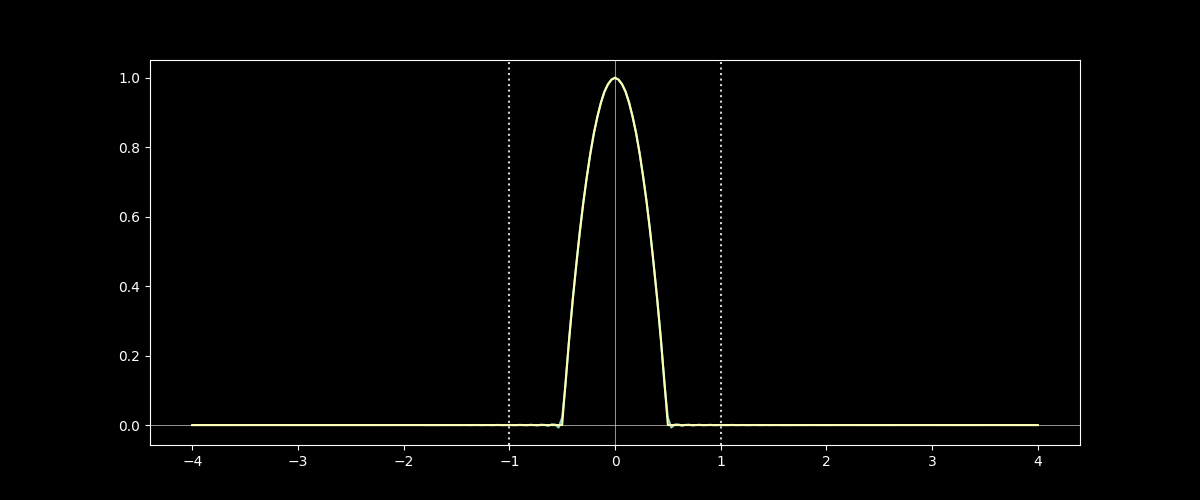

In [23]:
A.plot_field_1d(full)
A.add_1d_plot(f0)

In [24]:
Prop = lambda x, z: sum([P_prop1.propagate(x, z) + P_prop2.propagate(x, z)])
Ev = lambda x, z: sum([P_ev1.propagate(x, z) + P_ev2.propagate(x, z)])

Guided = lambda x, z: alpha_guided * Fg(x, z)

Rad = lambda x, z: Prop(x, z) + Ev(x, z)
Full = lambda x, z: Rad(x, z) + Guided(x, z)

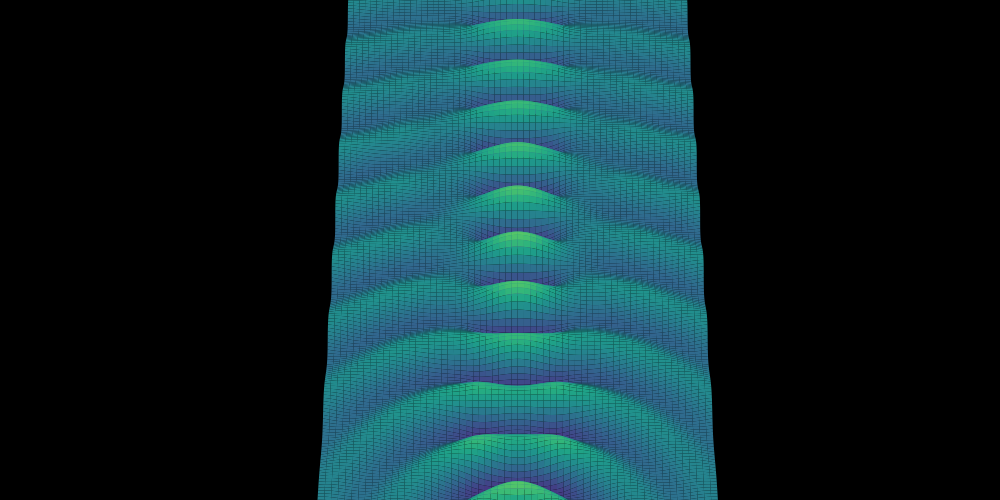

In [25]:
A.plot_field_2d_surface(Full, zmax=15, zref=220, rstride=1, cstride=4);

In [26]:
P_ev1.slice_propagate?

Signature:
P_ev1.slice_propagate(
    ind_var,
    slice_at=0,
    constant_variable='z',
    method='simpsons',
)
Docstring:
View cross section (slice) of propagated radiation field.

One may view the field at a constant value of z, yielding a
transverse view of the field at a particular point in its
direction of propagation, or a constant value of x,
yielding a view of its propagation at a fixed point in the
transverse domain.

Parameters
----------
ind_var : float or float array
    Independent variable along which to evaluate field.
slice_at : float, optional
    Value at which to take cross section. The default is 0.
constant_variable : str, optional
    Variable to hold constant. May be 'x' or 'z'. The default
    is 'z'.
method: str, optional
    Quadrature method.  May be left_endpoint, right_endpoint or
    trapezoidal. Default is trapezoid.

Returns
-------
ys: complex or complex array
    Field strengths at input variables and slice.
File:      ~/local/slab/slab.py
Type:    

(<Figure size 1200x500 with 1 Axes>, <Axes: >)

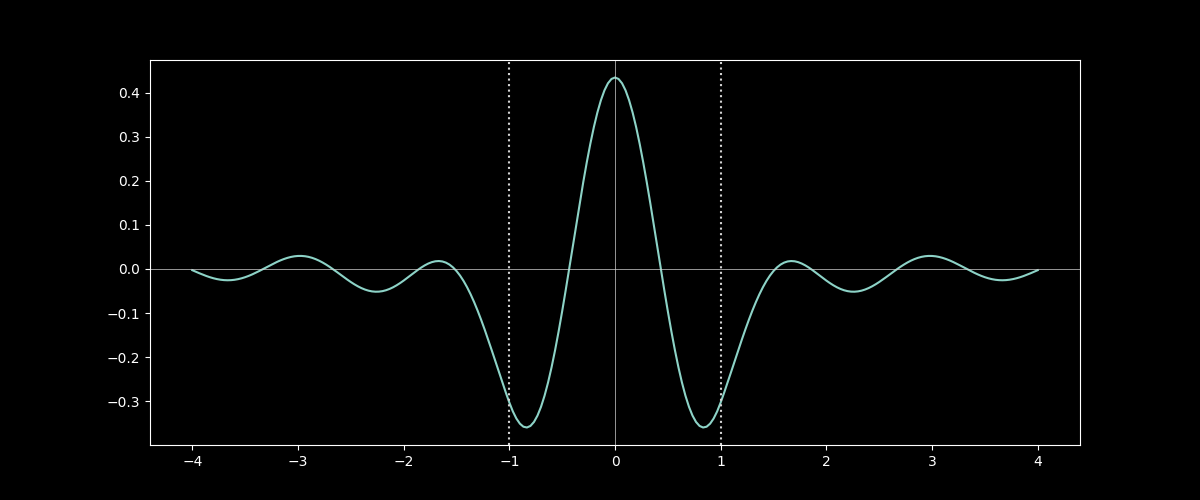

In [27]:
A.plot_field_1d(P_prop1.slice_propagate)

In [34]:
x0 = 0

leaky_exact_z = lambda z: sum([alpha * F(x0, z) for alpha, F in zip(alpha_leakys, F_leakys)])
leaky_contour_z = lambda z: sum([P.slice_propagate(z, slice_at=x0, constant_variable='x') for P in P_leaky])


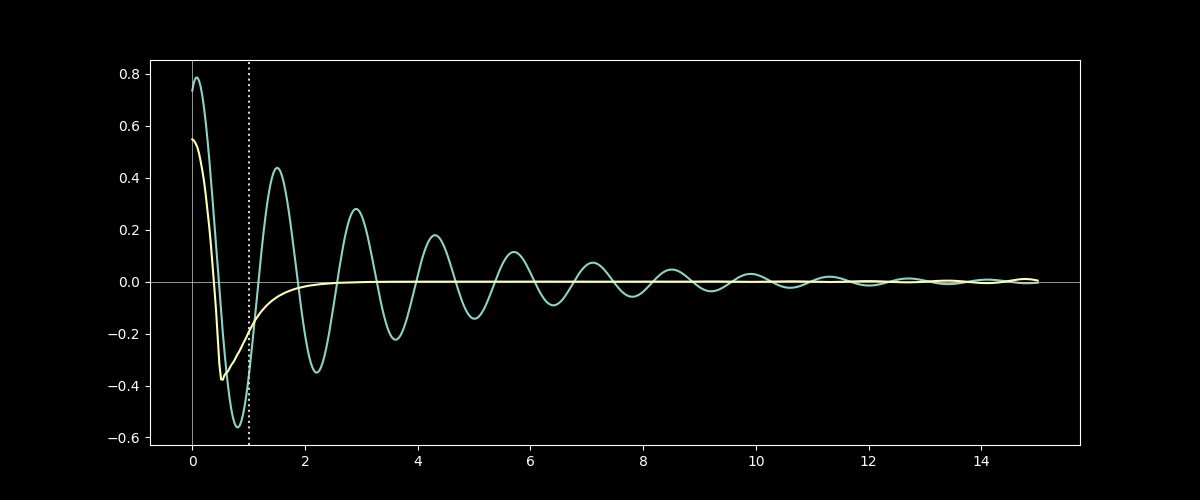

In [36]:
A.plot_field_1d(leaky_exact_z, xs=np.linspace(0, 15, 500))
A.add_1d_plot(rad, xs=np.linspace(0, 15, 500))

In [41]:
Leaky_exact = lambda x, z: sum([alpha * F(x, z) for alpha, F in zip(alpha_leakys, F_leakys)])
Leaky_contour = lambda x, z: sum([P.propagate(x, z) for P in P_leaky])